In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [ ]:
# def factor(df):
#     """
#     calculate_smart_money_S1
    
#     改进型聪明钱因子 (S1 = V)
#     使用成交量作为排序标准
#     """
#     avg_price = (df['open'] + df['high'] + df['low'] + df['close']) / 4
#     volume = df['volume']
    
#     factor_values = pd.Series(index=df.index, dtype=float)
#     window_size = 960
    
#     for i in range(window_size, len(df)):
#         window = df.iloc[i-window_size:i-1]
#         window_avg_price = avg_price.iloc[i-window_size:i-1]
#         window_volume = volume.iloc[i-window_size:i-1]
        
#         # 直接使用成交量作为S值
#         S = window_volume
        
#         sorted_indices = S.sort_values(ascending=False).index
#         sorted_volume = window_volume.loc[sorted_indices]
#         sorted_avg_price = window_avg_price.loc[sorted_indices]
        
#         cum_volume = sorted_volume.cumsum()
#         total_volume = sorted_volume.sum()
#         threshold = total_volume * 0.2
#         smart_indices = cum_volume[cum_volume <= threshold].index
        
#         if len(smart_indices) > 0:
#             smart_vwap = (sorted_avg_price.loc[smart_indices] * 
#                           sorted_volume.loc[smart_indices]).sum() / sorted_volume.loc[smart_indices].sum()
#         else:
#             smart_vwap = np.nan
        
#         all_vwap = (window_avg_price * window_volume).sum() / window_volume.sum()
        
#         if not np.isnan(smart_vwap) and all_vwap != 0:
#             factor_values.iloc[i] = smart_vwap / all_vwap
#         else:
#             factor_values.iloc[i] = np.nan
            
#     return factor_values

In [9]:
def factor(df):
    """
    优化后的 calculate_smart_money_S1
    使用成交量作为排序标准
    """
    # 预计算所有必要值
    avg_price = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    volume = df['volume'].values
    avg_price_vals = avg_price.values
    
    # 初始化因子值数组
    factor_values = np.full(len(df), np.nan)
    window_size = 960
    
    for i in range(window_size, len(df)):
        # 获取当前窗口切片索引
        start_idx = i - window_size
        end_idx = i - 1
        
        # 提取当前窗口数据
        window_avg_price = avg_price_vals[start_idx:end_idx]
        window_volume = volume[start_idx:end_idx]
        
        # 直接使用成交量作为S值
        S = window_volume
        
        # 按S值降序排序的索引
        sorted_idx = np.argsort(-S)
        sorted_volume = window_volume[sorted_idx]
        sorted_avg_price = window_avg_price[sorted_idx]
        
        # 计算累积成交量
        cum_volume = np.cumsum(sorted_volume)
        total_volume = cum_volume[-1]
        threshold = total_volume * 0.2
        
        # 找到聪明钱交易点 (前20%成交量)
        smart_mask = cum_volume <= threshold
        if np.any(smart_mask):
            smart_vwap = np.sum(sorted_avg_price[smart_mask] * 
                               sorted_volume[smart_mask]) / np.sum(sorted_volume[smart_mask])
        else:
            smart_vwap = np.nan
        
        # 计算整体VWAP
        all_vwap = np.sum(window_avg_price * window_volume) / np.sum(window_volume)
        
        # 计算因子值
        if not np.isnan(smart_vwap) and all_vwap != 0:
            factor_values[i] = smart_vwap / all_vwap
            
    return pd.Series(factor_values, index=df.index)

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.013049
   Rank_IC (Spearman): 0.017434
📊 信息比率:
   IR: 0.012048
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 129115
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


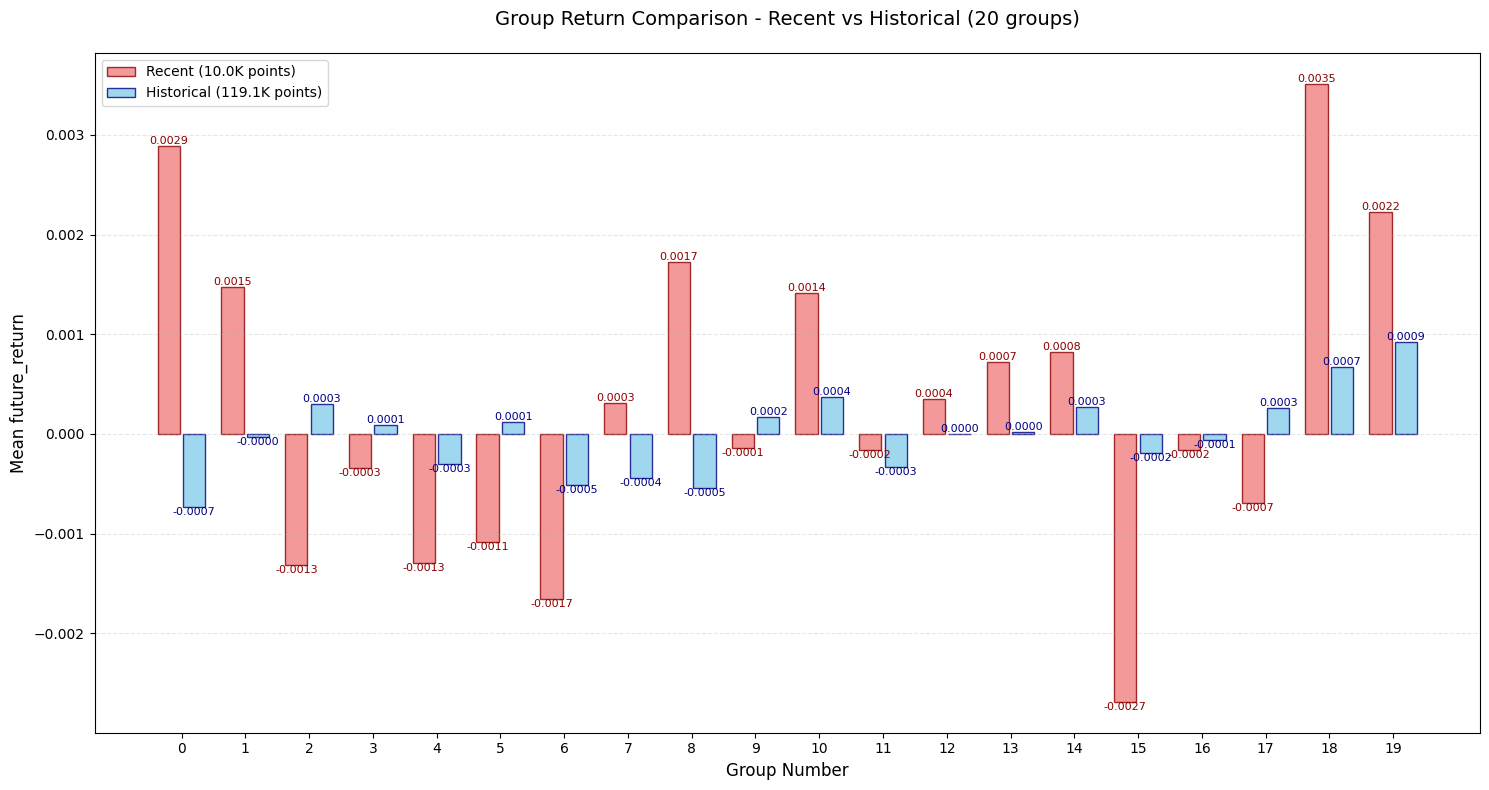

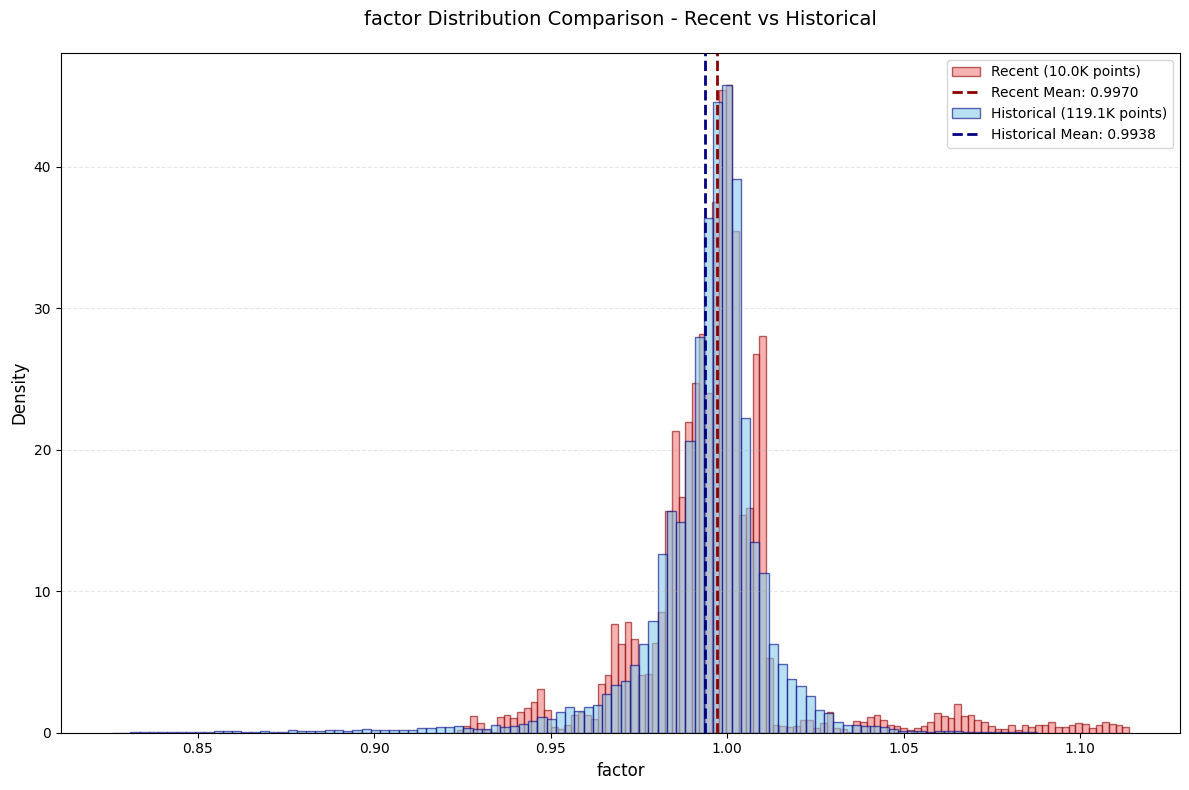

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [10]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

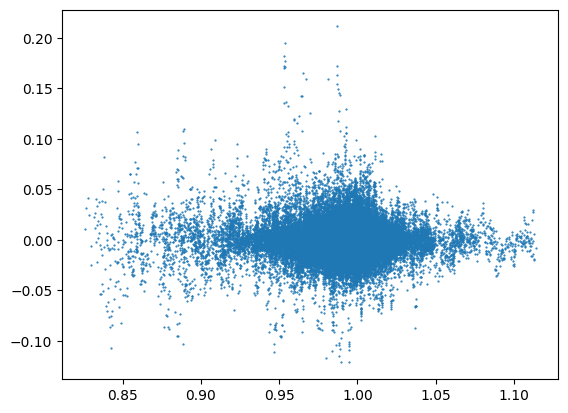

In [11]:
import matplotlib.pyplot as plt
plt.scatter(factor(df),df['close'].pct_change(-10), s=0.3)

In [12]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.018861339750867682,
 -0.005112911915198783,
 0.014914051462443538,
 0.010483253460075271,
 0.038151076098746815,
 -0.03256776311211331,
 -0.004632468053741429,
 -0.043001009531709926,
 0.021415753908790608,
 0.022174983482125533]

In [13]:
print(result)

{'correlation_analysis': {'IC': 0.013049238993495332, 'Rank_IC': 0.017433985317392774}, 'information_ratio': {'IR': 0.01204843903850926, 'group_correlations': [-0.018861339750867682, -0.005112911915198783, 0.014914051462443538, 0.010483253460075271, 0.038151076098746815, -0.03256776311211331, -0.004632468053741429, -0.043001009531709926, 0.021415753908790608, 0.022174983482125533], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0       0.8256   0.9638    0.9360      -0.0005      0.0225   6456
1       0.9638   0.9764    0.9710       0.0000      0.0145   6456
2       0.9764   0.9821    0.9797       0.0003      0.0125   6456
3       0.9821   0.9854    0.9839       0.0002      0.0127   6455
4       0.9854   0.9886    0.9870      -0.0005      0.0132   6456
5       0.9886   0.9909    0.9898      -0.0001      0.0115   6456
6       0.9909   0.9927    0.9919   